# Self-Organising Maps

In [1]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from evaluation_metrics import neighborhood_preservation_trustworthiness

import matplotlib.lines as mlines
import pandas as pd
import numpy as np

# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [2]:
data.shape

(105, 6)

In [3]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [4]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
65,24910,616580,24752
76,48800,1762580,36118
77,53894,1971646,36584
2,142890,82500,577
43,8680,4680,539
33,110850,997400,8998
91,15000,19000,1267
22,69960,356720,5099
69,32960,1105960,33555
8,165240,93690,567


In [5]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
65,0.130810,0.259492,0.615461
76,0.256263,0.741794,0.898078
77,0.283014,0.829781,0.909665
2,0.750358,0.034721,0.014347
43,0.045581,0.001970,0.013402
33,0.582107,0.419763,0.223736
91,0.078770,0.007996,0.031504
22,0.367381,0.150128,0.126787
69,0.173083,0.465451,0.834349
8,0.867725,0.039430,0.014099


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

Position : 1


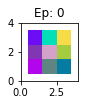

In [6]:
from our_som1 import SOM

# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Position : 1
SOM training epoches 20
neighborhood radius  2.6878753795222865
learning rate  0.009048374180359595
-------------------------------------
Position : 2
SOM training epoches 40
neighborhood radius  2.4082246852806923
learning rate  0.008187307530779819
-------------------------------------
Position : 3
SOM training epoches 60
neighborhood radius  2.157669279974593
learning rate  0.007408182206817179
-------------------------------------
Position : 4
SOM training epoches 80
neighborhood radius  1.9331820449317627
learning rate  0.006703200460356393
-------------------------------------
Position : 5
SOM training epoches 100
neighborhood radius  1.7320508075688772
learning rate  0.006065306597126334
-------------------------------------
Position : 6
SOM training epoches 120
neighborhood radius  1.5518455739153598
learning rate  0.005488116360940264
-------------------------------------
Position : 7
SOM training epoches 140
neighborhood radius  1.3903891703159093
learning rate  

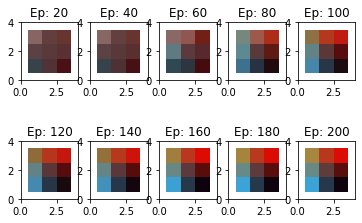

In [7]:
agri_som.train(trunc_data.values,num_epochs=200,init_learning_rate=0.01)

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [ ]:
def predict(df):
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df
clustered_df = trunc_data.apply(predict, axis=1)
clustered_df.iloc[0:10]

Now, joininig the labelled initial data

In [ ]:
joined_df = agri_data.join(clustered_df, rsuffix="_norm")
joined_df[0:10]

Visualize how the original data gets clustered in the SOM

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

fig = plt.figure()
# setup axes
ax = fig.add_subplot(111)
scale = 50
ax.set_xlim((0, agri_som.net.shape[0]*scale))
ax.set_ylim((0, agri_som.net.shape[1]*scale))
ax.set_title("Cash Crops Clustering by using SOM")

for x in range(0, agri_som.net.shape[0]):
    for y in range(0, agri_som.net.shape[1]):
        ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                     facecolor='white',
                     edgecolor='grey'))
legend_map = {}
        
for index, row in joined_df.iterrows():
    x_cor = row['bmu_idx'][0] * scale
    y_cor = row['bmu_idx'][1] * scale
    x_cor = np.random.randint(x_cor, x_cor + scale)
    y_cor = np.random.randint(y_cor, y_cor + scale)
    color = row['bmu'][0]
    marker = "$\\ " + row['Crop'][0]+"$"
    marker = marker.lower()
    ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
    label = row['Crop']
    if not label in legend_map:
        legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                          markersize=10, label=label)
plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
dataT = trunc_data[data['Crop']=='TOBACCO']
print(dataT)

In [ ]:
print(dataT.max())

In [ ]:
dataT = trunc_data[data['Crop']=='JUTE']
print(dataT.min())

In [ ]:
print(dataT.mean())

In [ ]:
trunc_data

In [ ]:
cd = pd.DataFrame(clustered_df['bmu'].apply(lambda x: x[0].tolist()), index = trunc_data.index)
cd = cd.bmu.apply(list).apply(pd.Series).astype(float)
cd

In [ ]:
neighborhood_preservation_trustworthiness(1, trunc_data, cd)